In [128]:
from ESN_model import *
import matplotlib.pyplot as plt

In [129]:
n_res_samples = 1000    
n_reservoir = 30                         
alpha = 0.35
sparsity_a = 0.07
sparsity_b = 0.2                                             
sr_a = 0.7                                              
sr_b = 1.5  

In [130]:
from glob import glob
import pickle
import os.path as osp

In [131]:
def get_data(file_path):
    with open(file_path, 'rb') as file:
        # Serialize and write the variable to the file
        data = pickle.load(file)
    return data

In [132]:
def load_single(file_path, display=False, percentile = 0):
    data = get_data(file_path)
    rmse = data['mean_rmse']
    
    if percentile:
        percentile_value = np.percentile(rmse,percentile)

        mask = data['mean_rmse'] < percentile_value
    else:
        mask = np.ones(len(rmse),dtype=bool)
    
    if display:
        sns.histplot(rmse, bins=30, kde=True )
        plt.axvline(percentile_value,color='orange')

        plt.show()
        
    reservoir = np.array(data['reservoir'])[mask] 
    w_in = np.array(data['w_in'])[mask]
    sparsity = np.array(data['sparsity'])[mask] 
    sparsity_mask = np.array(data['sparsity_mask'])[mask]
    feature_vectors = np.array(data['feature_vectors'])[mask] 
    
    return reservoir, w_in, sparsity, sparsity_mask, feature_vectors, rmse

In [133]:
def load_all(root_dir):
    paths = glob(osp.join(root_dir,'*.pickle'))
    all_data = get_data(paths[0])
    for idx, path in enumerate(paths[1:]):
        data = get_data(path)
        for key in all_data.keys():
            all_data[key] += data[key]
                
    return all_data
        

In [134]:
def select_the_best(data, percentile):
    """
        Returns mask for the ESNs with the best performance based on the passed percentile
    """
    threshold = np.percentile(data['mean_rmse'], percentile)
    mask = data['mean_rmse'] < threshold
    return mask

# Visualisation

In [279]:
root_dir = 'reservoir_data/res_30_more_info/'
all_data = load_all(root_dir)

In [280]:
threshold = np.percentile(all_data['mean_rmse'], 14)
data_arr = np.array(all_data['mean_rmse'])
data = data_arr[data_arr<threshold]

In [281]:
len(data)

8400

Text(0.5, 0, 'Mean RMSE')

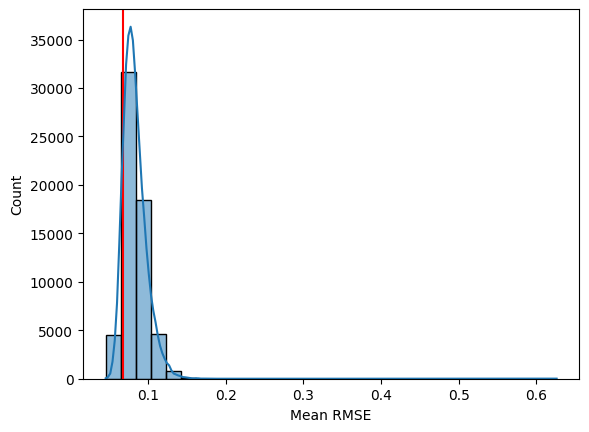

In [282]:
import seaborn as sns

plt.axvline(x = threshold, color = 'r')

sns.histplot(data_arr,bins=30, kde=True)
plt.xlabel('Mean RMSE')
#plt.savefig("images/Reservoir_Dataset/res23-histogram.png")
#plt.savefig("images/Reservoir_Dataset/res23-histogram.pdf")
#plt.savefig("images/Reservoir_Dataset/res23-histogram.svg")

In [283]:
all_features = np.concatenate(all_data['feature_vectors'])
np.random.shuffle(all_features)

In [284]:
from umap import UMAP

def draw_umap(data, labels=None, n_neighbors=20, min_dist=0.9, n_components=3, metric='euclidean', title='', dot_size=1):
    fit = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), s=dot_size)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], s=dot_size, c=labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=dot_size, c=labels)
    plt.title(title, fontsize=18)

In [285]:
from sklearn.decomposition import PCA

def draw_pca(data, labels=None, n_components=3, title='', dot_size=1):
    fit = PCA(n_components=n_components)
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), s=dot_size)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], s=dot_size, c=labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=dot_size, c=labels)
    plt.title(title, fontsize=18)

In [286]:
from sklearn.manifold import TSNE

def draw_tsne(data, labels=None, n_components=3, perplexity=30, title='', dot_size=1):
    fit = TSNE(n_components=n_components)
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), s=dot_size)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], s=dot_size, c=labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=dot_size, c=labels)
    plt.title(title, fontsize=18)

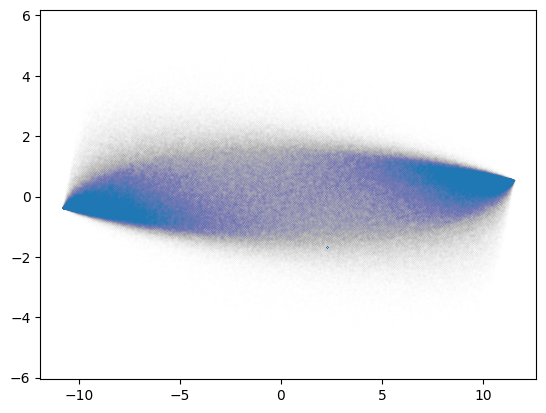

In [278]:
draw_pca(all_features, n_components=2,dot_size=0.00001)
#plt.savefig("images/Reservoir_Dataset/res23-feature_PCA_2d.png")
#plt.savefig("images/Reservoir_Dataset/res23-feature_PCA_2d.pdf")
#plt.savefig("images/Reservoir_Dataset/res23-feature_PCA_2d.svg")

In [287]:
size = 10_000

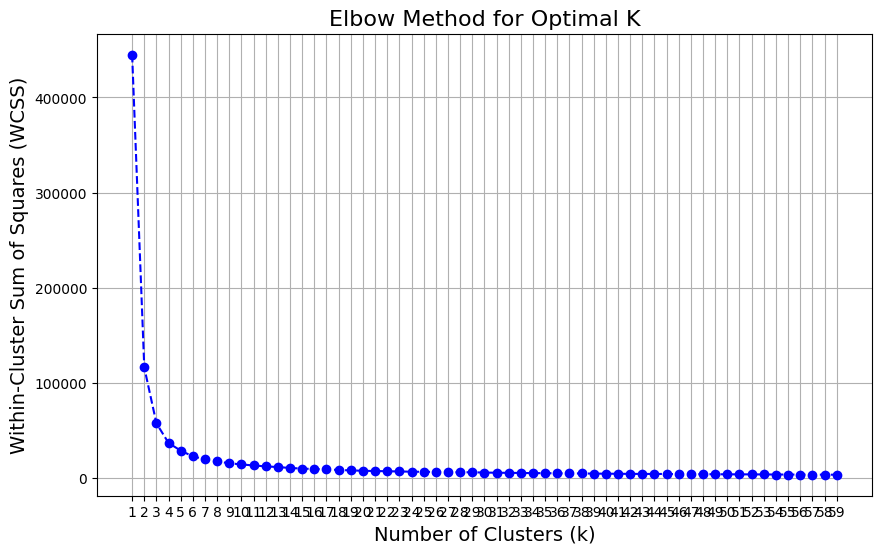

In [239]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 60)  # Test k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_features[:size])
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.xticks(k_values)
plt.grid()
#plt.savefig('images/Reservoir_Dataset/res23-elbow.png')
#plt.savefig('images/Reservoir_Dataset/res23-elbow.pdf')
#plt.savefig('images/Reservoir_Dataset/res23-elbow.svg')

In [248]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(all_features[:size])
cluster_labels = kmeans.labels_

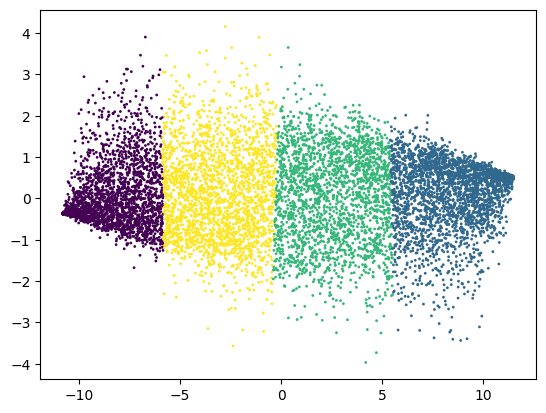

In [249]:
draw_pca(all_features[:size], cluster_labels,n_components=2)
#plt.savefig('images/Reservoir_Dataset/res23-k-means_projections_PCA_4clusters.png')
#plt.savefig('images/Reservoir_Dataset/res23-k-means_projections_PCA_4clusters.pdf')
#plt.savefig('images/Reservoir_Dataset/res23-k-means_projections_PCA_4clusters.svg')

In [288]:
mask = select_the_best(all_data, percentile=2)

In [289]:
np.array(all_data['mean_rmse'])[mask]

array([0.05910975, 0.05764405, 0.05854095, ..., 0.05434987, 0.05801759,
       0.05445282])

In [290]:
def make_adjacency_matrix(w_res, w_in):
    n_input_neurons = w_in.shape[1]
    zeros = np.zeros((n_input_neurons,n_input_neurons))
    adj_w_in = np.hstack([zeros, w_in.T])
    
    n_reservoir_neurons = w_res.shape[0]
    
    zeros_w_res = np.zeros((n_reservoir_neurons, n_input_neurons))
    adj_w_res = np.hstack([zeros_w_res, w_res.T])
    adj = np.vstack([adj_w_in, adj_w_res])
    return adj

In [291]:
w_res = np.array(all_data['reservoir'])[mask][0]
w_in = np.array(all_data['w_in'])[mask][0]

In [292]:
np.array(all_data['sparsity'])[mask][0]

0.17264685636641453

In [293]:
adj = make_adjacency_matrix(w_res, w_in)

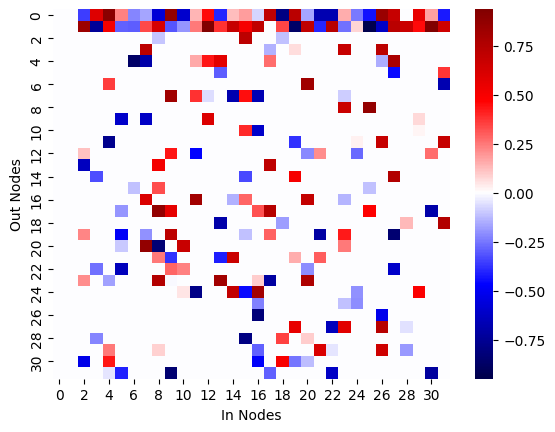

In [294]:
import seaborn as sns
sns.heatmap(adj, cmap ='seismic', center=0)
plt.ylabel("Out Nodes")
plt.xlabel("In Nodes")
plt.savefig('images/Reservoir_Dataset/res30-weighted_adjacency_matrix_sparsity0-17.png')
plt.savefig('images/Reservoir_Dataset/res30-weighted_adjacency_matrix_sparsity0-17.pdf')
plt.savefig('images/Reservoir_Dataset/res30-weighted_adjacency_matrix_sparsity0-17.svg')


In [295]:
def weighted_adj_to_unweighted(adj, epsilon):
    negative = adj < -epsilon 
    positive = adj > epsilon
    return np.logical_or(negative, positive)

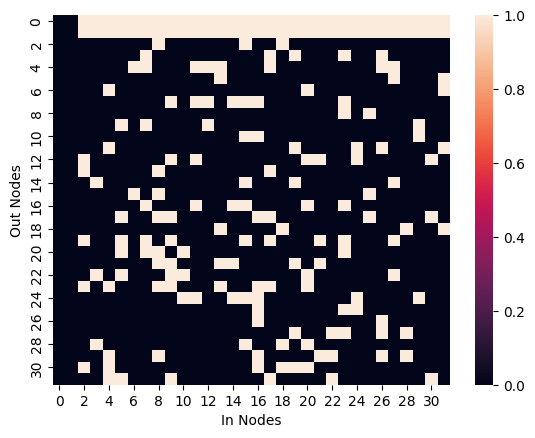

In [296]:
uw_adj = weighted_adj_to_unweighted(adj, 0.0001)
sns.heatmap(uw_adj)
plt.ylabel("Out Nodes")
plt.xlabel("In Nodes")
plt.savefig('images/Reservoir_Dataset/res30-unweighted_adjacency_matrix_sparsity0-17.png')
plt.savefig('images/Reservoir_Dataset/res30-unweighted_adjacency_matrix_sparsity0-17.pdf')
plt.savefig('images/Reservoir_Dataset/res30-unweighted_adjacency_matrix_sparsity0-17.svg')

In [297]:
symetric = np.logical_or(uw_adj,uw_adj.T)

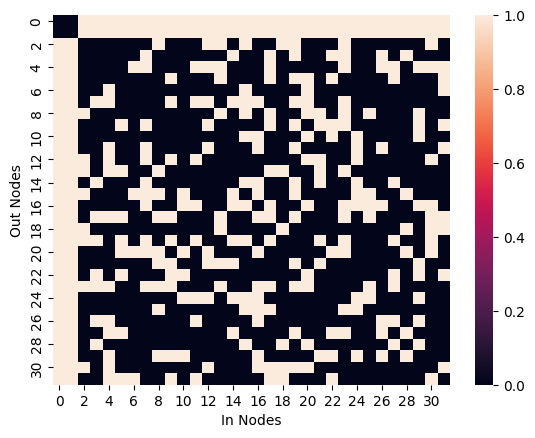

In [298]:
sns.heatmap(symetric)
plt.ylabel("Out Nodes")
plt.xlabel("In Nodes")
plt.savefig('images/Reservoir_Dataset/res30-unweighted_symetric_adjacency_matrix_sparsity0-17.png')
plt.savefig('images/Reservoir_Dataset/res30-unweighted_symetric_adjacency_matrix_sparsity0-17.pdf')
plt.savefig('images/Reservoir_Dataset/res30-unweighted_symetric_adjacency_matrix_sparsity0-17.svg')

In [171]:
np.logical_not(np.eye(9))

array([[False,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True, False,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False]])

In [196]:
def uw_adj_to_edge_index(adj, symetric = False, remove_self_loops = False):
    if remove_self_loops:
        adj = np.logical_and(adj, np.logical_not(np.eye(adj.shape[0])))
        
    if symetric:
        arr = np.triu(adj).nonzero()
    else:
        arr = adj.nonzero()
    edge_index = np.array(arr)
    return edge_index

In [197]:
from torch_geometric.utils import to_dense_adj
import torch

In [198]:
uw_adj = uw_adj_to_edge_index(symetric)

arr = to_dense_adj(torch.Tensor(uw_adj).to(torch.int64))

<Axes: >

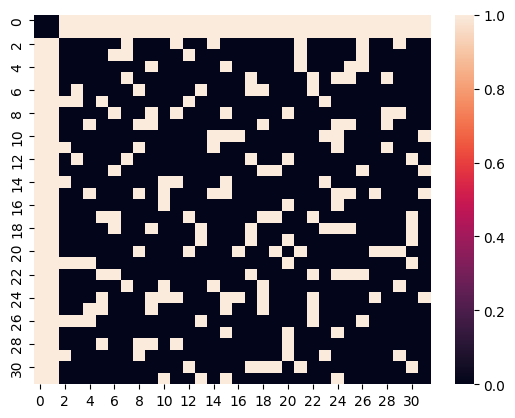

In [199]:
sns.heatmap(arr[0])

In [216]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [ ]:
def create_data(data_dict, idx, epsilon = 0.0001):
    
    w_res = np.array(data_dict['reservoir'][idx])
    w_in = np.array(data_dict['w_in'][idx])
    sparsity_masks = np.array(data_dict['sparsity_mask'][idx])
    sparsity = np.array(data_dict['sparsity'][idx])
    feature_vectors = np.array(data_dict['feature_vectors'][idx])
    
    adj = make_adjacency_matrix(w_res, w_in)
    uw_adj = weighted_adj_to_unweighted(adj, epsilon)

    edge_index = torch.Tensor(uw_adj_to_edge_index(adj)).to(torch.int64)
    
    #edge_features

    y = torch.Tensor(adj)
    x = torch.Tensor(feature_vectors)
    mrmse = 

    data = Data(x=x, edge_index=edge_index, y=y)

    data.sparsity_mask = torch.Tensor(sparsity_mask).to(torch.bool)
    data.sparsity = sparsity
        
    return data

In [202]:
def create_data(w_res, w_in, sparsity_mask, sparsity, feature_vectors, epsilon = 0.0001):
    adj = make_adjacency_matrix(w_res, w_in)
    uw_adj = weighted_adj_to_unweighted(adj, epsilon)

    edge_index = torch.Tensor(uw_adj_to_edge_index(adj)).to(torch.int64)
    
    #edge_features

    y = torch.Tensor(adj)
    x = torch.Tensor(feature_vectors)
    mrmse = 

    data = Data(x=x, edge_index=edge_index, y=y)

    data.sparsity_mask = torch.Tensor(sparsity_mask).to(torch.bool)
    data.sparsity = sparsity
        
    return data

In [219]:
def create_data_list(root_dir, percentile, epsilon = 0.0001):
    all_data = load_all(root_dir)
    mask = select_the_best(all_data, percentile)
    
    reservoirs = np.array(all_data['reservoir'])
    w_ins = np.array(all_data['w_in'])
    sparsity_masks = np.array(all_data['sparsity_mask'])
    sparsities = np.array(all_data['sparsity'])
    feature_vectors = np.array(all_data['feature_vectors'])
    
    indeces = np.where(mask == True)[0]
    
    data_list = []
    for idx in indeces:
        data = create_data(reservoirs[idx],
                           w_ins[idx],
                           sparsity_masks[idx],
                           sparsities[idx],
                           feature_vectors[idx],
                           epsilon)
        data_list.append(data)
    return data_list
    

In [220]:
data_list = create_data_list('reservoir_data/',2)



In [240]:
with open('reservoir_data/data_list.pkl', 'wb') as file:
    pickle.dump(data_list, file)

<Axes: >

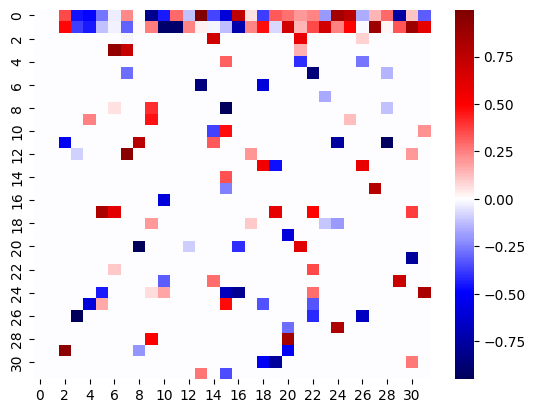

In [223]:
sns.heatmap(data_list[0].y, cmap='seismic', center = 0)

In [ ]:
def get_data(file_path):
    with open(file_path, 'rb') as file:
        # Serialize and write the variable to the file
        data = pickle.load(file)
    return data

In [ ]:
2.71